In [970]:
### IMPORTS ###
import os
import struct
import numpy as np
import math
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, fixed
import ipywidgets as widgets

In [971]:
### SETTINGS ###
np.set_printoptions(precision=3, suppress=True, threshold=np.inf)

In [972]:
### FOLDER SETTINGS ###
input_folder = "../output/"

file_solution_path = input_folder + "/system_solution.dat"  # Replace with your actual file path
rhs_path = input_folder + "/system_rhs.dat"  # Replace with your actual file path
residual_path = input_folder + "/system_residual.dat"  # Replace with your actual file path

In [973]:
format_string = '<d'  # '<d' for little-endian, '>d' for big-endian

In [974]:
### Analytical solution functions ###

# This function creates a ND numpy array
def np_u_analytical_poisson(ndims, global_domain_begin, global_domain_end, grid_size):
    # Create coordinate arrays for each dimension
    p_coords = [np.linspace(global_domain_begin[i], global_domain_end[i], grid_size[i]) for i in range(ndims)]
    
    # Generate meshgrid from coordinate arrays
    meshgrid = np.meshgrid(*p_coords, indexing='ij')
    
    # Compute function values
    #func_val = np.prod(np.sin(np.pi * np.stack(meshgrid)),axis=0)
    func_val = np.sin(np.pi * meshgrid[1]) * np.sin(2 * np.pi * meshgrid[0]) + meshgrid[1] * np.sin(np.pi * meshgrid[0])
    
    return func_val, meshgrid

In [975]:
### PLOTTING FUNCTIONS ###

def plot_1D(true_solution, approximate_solution):
    error = np.abs(approximate_solution - true_solution)
    l2_error = np.linalg.norm(approximate_solution - true_solution, 2) #/ (grid_size[0] * grid_size[1])
    print(f"Max error: {np.max(error):.1e}, L2 error: {l2_error:.1e}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    x_values = np.arange(len(true_solution))

    # True solution plot
    axes[0].scatter(x_values, true_solution, color='blue', linestyle='--', label='True Solution')
    axes[0].set_title('True Solution')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[0].legend()

    # Approximate solution plot
    axes[1].scatter(x_values, approximate_solution, color='green', linestyle='--', label='Approximate Solution')
    axes[1].set_title('Approximate Solution')
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Y')
    axes[1].legend()

    # Error plot
    axes[2].scatter(x_values, error, color='red', linestyle='--', label='Error')
    axes[2].set_title('Error')
    axes[2].set_xlabel('X')
    axes[2].set_ylabel('Y')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

def plot_2D(true_solution, approximate_solution):
    error = np.abs(approximate_solution - true_solution)
    l2_error = np.linalg.norm(approximate_solution - true_solution, 2) #/ (grid_size[0] * grid_size[1])
    print(f"Max error: {np.max(error):.1e}, L2 error: {l2_error:.1e}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # True solution plot
    cax1 = axes[0].imshow(true_solution, cmap='viridis', origin='lower')
    axes[0].set_title('True Solution')
    fig.colorbar(cax1, ax=axes[0], orientation='vertical')

    # Approximate solution plot
    cax2 = axes[1].imshow(approximate_solution, cmap='viridis', origin='lower')
    axes[1].set_title('Approximate Solution')
    fig.colorbar(cax2, ax=axes[1], orientation='vertical')

    # Error plot
    cax3 = axes[2].imshow(error, cmap='hot', origin='lower')
    axes[2].set_title('Error')
    fig.colorbar(cax3, ax=axes[2], orientation='vertical')

    plt.tight_layout()
    plt.show()

def plot_slice_3D(true_solution, approximate_solution, z_index=0):
    error = np.abs(approximate_solution - true_solution)
    l2_error = np.linalg.norm(approximate_solution - true_solution, 2) #/ (grid_size[0] * grid_size[1])
    print(f"Max error: {np.max(error):.1e}, L2 error: {l2_error:.1e}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # True solution plot for the given slice
    cax1 = axes[0].imshow(true_solution[:, :, z_index], cmap='viridis', origin='lower')
    axes[0].set_title(f'True Solution (Slice at z={z_index})')
    fig.colorbar(cax1, ax=axes[0], orientation='vertical')

    # Approximate solution plot for the given slice
    cax2 = axes[1].imshow(approximate_solution[:, :, z_index], cmap='viridis', origin='lower')
    axes[1].set_title(f'Approximate Solution (Slice at z={z_index})')
    fig.colorbar(cax2, ax=axes[1], orientation='vertical')

    # Error plot for the given slice
    cax3 = axes[2].imshow(error[:, :, z_index], cmap='hot', origin='lower')
    axes[2].set_title(f'Error (Slice at z={z_index})')
    fig.colorbar(cax3, ax=axes[2], orientation='vertical')

    plt.tight_layout()
    plt.show()

In [976]:
data = np.fromfile(file_solution_path, dtype=np.float64)
approximate_solution = np.array(data)

data = np.fromfile(rhs_path, dtype=np.float64)
rhs = np.array(data)

data = np.fromfile(residual_path, dtype=np.float64)
residual = np.array(data)

In [977]:
ndims = 2
num_data_per_elements = 1
grid_size = [128,128,4]

if(ndims == 1):
    layout = (grid_size[0], num_data_per_elements)

if(ndims == 2):
    layout = (grid_size[0], grid_size[1], num_data_per_elements)

if(ndims == 3):
    layout = (grid_size[0], grid_size[1], grid_size[2], num_data_per_elements)

print("Layout: ", layout)

Layout:  (128, 128, 1)


In [978]:
domain_begin_array = np.full(ndims, 0.0)
domain_end_array = np.full(ndims, 1.0)

In [979]:
# Reshape the data into a 2D array
approximate_solution = np.array(approximate_solution)
rhs = np.array(rhs)
residual = np.array(residual)

approximate_solution = approximate_solution.reshape(layout)
rhs = rhs.reshape(layout)
residual = residual.reshape(layout)

approximate_solution = np.squeeze(approximate_solution)
rhs = np.squeeze(rhs)
residual = np.squeeze(residual)
print(approximate_solution.shape)

(128, 128)


In [980]:
#print(approximate_solution.T)

In [981]:
#print(rhs.T)

In [982]:
true_solution, mesh = np_u_analytical_poisson(ndims, domain_begin_array, domain_end_array, layout)


In [983]:
# NxM, stencil size, Max error, L2 error
# 8x8, 3x3, Max error: 1.5e-02, L2 error: 8.7e-04
# 16x16, 3x3, Max error: 9.0e-04, L2 error: 2.4e-05
# 32x32, 3x3, Max error: 8.3e-04, L2 error: 1.3e-05
# 64x64, 3x3,Max error: 1.1e-04, L2 error: 8.6e-07

# 8x8, 5x5, Max error: 9.3e-04, L2 error: 7.7e-05
# 16x16, 5x5, Max error: 3.0e-05, L2 error: 1.2e-06
# 32x32, 5x5, Max error: 2.8e-05, L2 error: 4.4e-07

# 8x8, 7x7, Max error: 8.7e-05, L2 error: 7.2e-06
# 16x16, 7x7, Max error: 9.5e-06, L2 error: 2.6e-07
# 32x32, 7x7, Max error: 8.6e-07, L2 error: 1.0e-08
# 64x64, 7x7, Max error: 4.7e-08, L2 error: 3.1e-10

In [984]:
if(ndims == 1):
    plot_1D(true_solution, approximate_solution)

Max error: 4.8e-10, L2 error: 1.0e-09


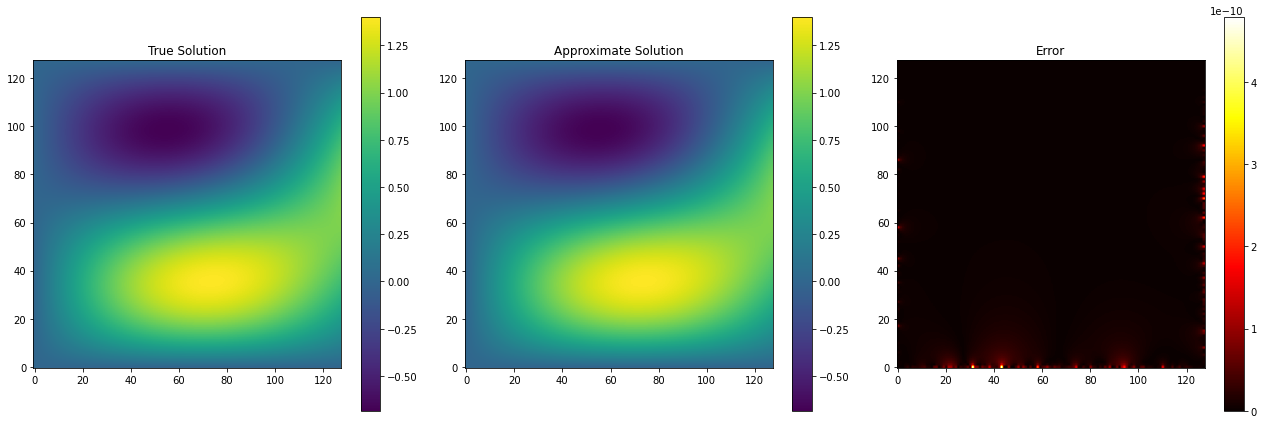

In [985]:
if(ndims == 2):
    #plot_2D(true_solution, approximate_solution)
    plot_2D(true_solution, rhs)
    #plot_2D(true_solution, residual)

In [986]:
if(ndims == 3):
    # Adjust the max value of the slider to match the size of your 3rd dimension
    z_slider = IntSlider(min=0, max=true_solution.shape[-1]-1, step=1, value=0, description='Z index')

    # Use 'fixed' for non-interactive arguments
    interact(plot_slice_3D, true_solution=fixed(true_solution), approximate_solution=fixed(approximate_solution), error=fixed(error), z_index=z_slider)